<a href="https://colab.research.google.com/github/tinahuang222/NucleiSegmentation/blob/master/PREPROCESSING/Aggregate_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
%matplotlib inline

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle

#specific versions required for downloaded code segments
#!pip3 install -q scipy==1.2.0
#!pip3 install -q imgaug==0.2.6


################################################################################
# Read Data from google drive
################################################################################
from google.colab import drive #for loading gdrive data
drive.mount('/content/gdrive')

###                     MAIN DIRECTORY NAMES
gdir = '/content/gdrive/My Drive/'
main_directory = gdir

#
#directory of top level of user data
#

use_pickle = 0  #use pre-saved pickle data insted of reprocessing data



#directory to CSV files from Tina. This contains mask1 and mask2 zip data
features_dir = os.path.join(gdir,'TILE_PREPROCESSING',
                                   'Feature_extractions_unzipped_merge')


#
#pickle file used to store full image sets, which take more than a minute to run
#
pickle_dir = os.path.join(main_directory, 'TILE_PREPROCESSING')
pickle_file = os.path.join(pickle_dir,'PICKLE_FEATURES_REMAPPED.pck')
pickle_output_file = os.path.join(pickle_dir,'PICKLE_FEATURES_AVERAGE_OUTPUT.pck')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def get_quadrants(data,fname):
    #
    #
    #get quadrants from center of mass of mask. Quadrants are 0-255 in xy
    #data[1] contains x and y locations in fractional pixels - close enough
    #
    #
    quadrant_locations=[]
    xypos = []

    nx = 512
    for ii in range(0,len(data)): #each row is one mask id
        from ast import literal_eval as make_tuple
        #make_tuple("(1,2,3,4,5)")
        xy = make_tuple(data[ii][1])
        xypos.append(xy)
        xx = xy[0] - nx/2
        yy = xy[1] - nx/2

        if (xx > 0): #we're in 0 or 3
            ychoice = [0, 3]
            if (yy > 0):
                quad = ychoice[1] #3
            else:
                quad = ychoice[0] #0
        else:
            ychoice = [1 ,2]
            if (yy > 0):
                quad = ychoice[1] #2
            else:
                quad = ychoice[0] #1
        quadrant_locations.append(quad) #listing of quadrants for all files
    return quadrant_locations

In [36]:
'''
Open CSV files and read all data
'''

feature_files = os.listdir(features_dir)
image_name = []

cdata={} #hold all of the pandas data, easier to work outside of pandas
quadrant_file ={}  #store quadrant for each mask across all files
for filename in feature_files:
    pdata = pd.read_csv(os.path.join(features_dir,filename))




    full_filename = os.path.join(features_dir,filename)
    #print('Processing Mask File: ',filename)
    root_ext = os.path.splitext(filename) #will return two parts, name and ext
    image_name.append(root_ext[0])
    fname = root_ext[0]  #just the filename without extension for key use

    #quadrant_file[root_ext[0]] = []
    cdata[root_ext[0]] ={} #list to hold lists from pandas

    tile_data = []

    with open(full_filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        header = next(csv_reader) #,none) #skip header row
        line_count = 0
        data = [row for row in csv_reader]


    #
    # Get all quadrants for this file using the center position (entry #1 in 
    # pandas dataset)
    #

    #quadrant_file[fname].append(get_quadrants(data,fname))
    quadrant_file[root_ext[0]] = get_quadrants(data,fname)
    

    #for each feature (115), store them off and then get an avg per quadrant
    if 'mask_num' in pdata.columns:
        temp_col = pdata.mask_num
    else:
        #this doesn't have the needed column for masks, skip it, for now
        print('MISSING mask_num data in ',root_ext[0])
        continue

    knames = pdata.keys()
    counter = 0

    from ast import literal_eval

    for kk in knames:
        #print(np.array(literal_eval(lst)))
        #print('shape of 0 ',kk, np.shape(pdata[kk][0]))
        #print(type(pdata[kk][0]))
        #anything not a value, needs to be handled differently
        
        
        
        if (isinstance(pdata[kk][0], str) == True):
            #print('found longer list ',pdata[kk])
            #print('Length of entry 0 is ',len(pdata[kk][0]), pdata[kk][0])

            #HASH CHECK 
            #look for , in string to find tuples. If no comma, this is 
            #probably one of those hash values
            comma_status = pdata[kk][0].find(',')
            if (comma_status == -1):
                #no comma found, likely not a tuple
                #print('NO COMMA in string, skipping this key: ',kk, pdata[kk][0])
                continue

            try:
                #try to convert string tuple into a tuple. This will convert
                #the whole pandas column
                temp=pdata[kk].apply(lambda x: literal_eval(str(x)))
                #temp=pdata[kk].apply(ast.literal_eval)
            except TypeError:
                print('Exception for ',kk)
        else:
            temp= pdata[kk]

        #if we didn't get tossed out of this loop, store the transferred data 
        #into the new storage area as a list
        cdata[fname][kk] =[]
        cdata[fname][kk]= temp


    #for kk in knames:
    #    temp_col = pdata[kk]
    #    print(kk)
    #    #print('id, len col = ',counter,len(temp_col))
    ##    if (len(np.shape(temp_col)) > 1):
    #        print('found 2+ tuple')
        counter = counter + 1

print('COMPLETED SIFTING THROUGH CSV FILES')

COMPLETED SIFTING THROUGH CSV FILES


In [68]:

fname = cdata.keys() #each key of this dictionary is the CSV file

total_averages ={}
for fname in image_name:

    #
    # Extract quadrant indices for this filename set
    #
    qindex={}
    for qloop in range(0,4):
        #loop through all quadrants
        index = np.where(np.asarray(quadrant_file[fname]) == qloop )
        qindex[qloop]= index

    #
    # Get keys present in series
    #
    key_list = cdata[fname].keys() #cdata['15444_126336_34048'].keys()

    averages={} #set aside dictionary just for this file
    for kk in key_list:
        #for every entry under this key, get quadrant number and add sum to
        #quadrant list
        #print(cdata[fname][kk][0])
        temp = cdata[fname][kk]

        #tuples represent locations or areas, handle them differently
        record = isinstance(temp[0],tuple)
        if (record == True):
            #skipping tuples, this will also leave out this fieldname from the 
            #names as keys list, so the output is stil 1:1 with fields left
            #print('Tuple found @ ', kk, temp[0])
            continue
        else:
            #find quadrant and average 
            quad_avg=[]
            for ii in range(0,4):
                qval = np.average(temp[qindex[ii][0]])
                quad_avg.append(qval)
            averages[kk] = quad_avg
    total_averages[fname] = averages


#save pickle if running for first time
if (use_pickle == 0):

    with open(pickle_file, 'wb') as f:
        pickle.dump(total_averages, f)
#quadrant_file[fname]

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
'''
Get the arrays by column name and put them together into one giant array
'''
field_names = total_averages['10009_49280_17920'].keys()
full_array = {}
for ii in range(0,len(field_names)):
    full_array[ii]=[]



for fname in image_name:
    for fcounter,field in enumerate(field_names):
            full_array[fcounter].extend(total_averages[fname][field])

with open(pickle_output_file, 'wb') as f:
    output_data = [full_array, list(field_names)]
    pickle.dump(output_data, f)

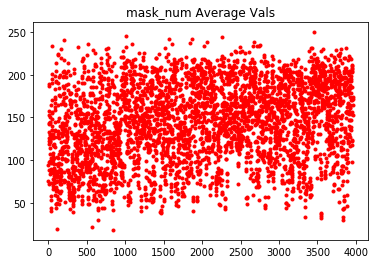

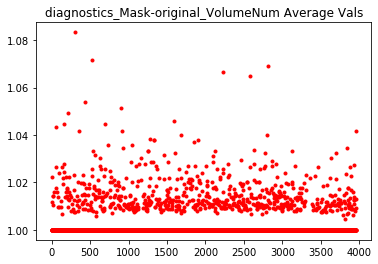

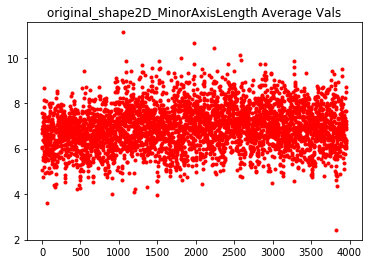

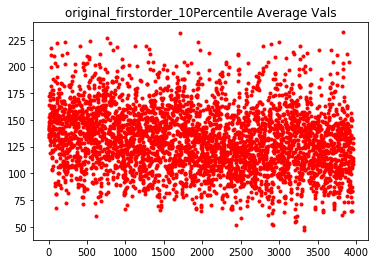

In [84]:

for ii in range(0,20,5):
    plt.figure()
    plt.plot(full_array[ii],'r.')
    tname = list(field_names)[ii] + ' Average Vals'
    plt.title(tname)


In [81]:
a=list(field_names)
a[3]

'diagnostics_Image-original_Maximum'